## notebook to plot correlations between different features and brain parcel timecourses

In [252]:
import nibabel as nb
import nilearn as nl
import hcp_utils as hcp
import numpy as np
import pandas as pd
from os import walk

import hrf_tools
import scipy

In [253]:
tsv_dir='../sourcedata/data/merlin/features/'

In [254]:
df=pd.read_csv(f'{tsv_dir}any_faces.tsv', sep='\t')
any_faces=df['value'][0:15135]
df=pd.read_csv(f'{tsv_dir}face.tsv', sep='\t')
face=df['value'][0:15135]

df=pd.read_csv(f'{tsv_dir}speech.tsv', sep='\t')
speech=df['value'][0:15135]
df=pd.read_csv(f'{tsv_dir}as-Speech.tsv', sep='\t')
as_speech=df['value'][0:15135]



df=pd.read_csv(f'{tsv_dir}any_faces_edited.tsv', sep='\t')
any_faces_edited=df['any_faces_edited'][0:15135]
df=pd.read_csv(f'{tsv_dir}speech_edited.tsv', sep='\t')
speech_edited=df['speech_edited'][0:15135]

In [255]:
d=pd.DataFrame({'face': face, 'any_faces': any_faces, 'any_faces_edited': any_faces_edited, 'speech': speech, 'as_speech': as_speech, 'speech_edited': speech_edited})

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

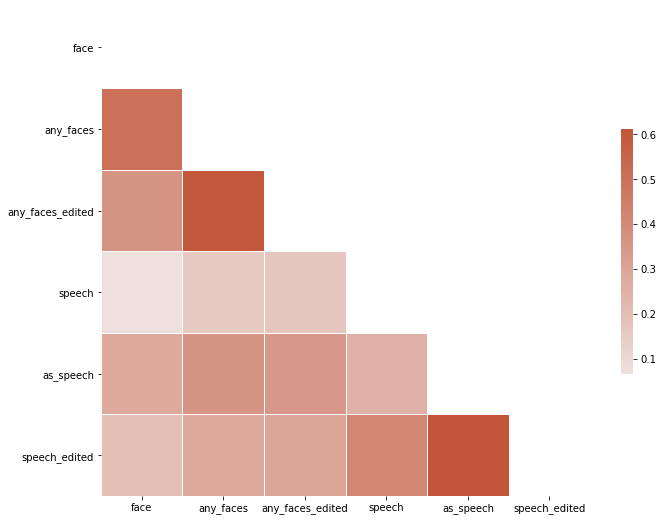

In [257]:
corr = d.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Now compare the face features (convolved) to MMP FFC

In [258]:
#load timecourse of FFCs from merlin subjects

timecourse_list=[]
sub_list=[]
parcel_list_id=[18,198,1,181,56,236,8,188]
parcel_list_name=['L_FFC','R_FFC','L_V1','R_V1','L_6v','R_6v','L_4','R_4']


parcel_dir='/om2/user/jsmentch/projects/nat_img/sourcedata/data/merlin/brain/merlin_cifti_clean_smooth_mmp/'
filenames = next(walk(parcel_dir), (None, None, []))[2]  # [] if no file

for p_i,parcel_id in enumerate(parcel_list_id):
    parcel_name=parcel_list_name[p_i]
    for f in filenames:
        sub_id=f[12:18]

        im_file = f'{parcel_dir}{f}'
        img = nb.load(im_file)
        img_y = img.get_fdata()
        #get FFC timecourse
        #timecourse=img_y[:1009,198]#FFC
        #timecourse=img_y[:1009,1]#L_V1
        timecourse=img_y[:1009,parcel_id]
        timecourse_list.append(timecourse)
        sub_list.append(f'{sub_id}_{parcel_name}')
timecourse_list=np.asarray(timecourse_list)
np.nan_to_num(timecourse_list, copy=False, nan=0.0 ) #some have NaNs...

array([[ 0.41645983, -0.24256022, -0.65899456, ..., -0.04160812,
        -0.15329957, -0.21139655],
       [ 1.67985868,  1.17254639,  0.78647214, ...,  0.51846457,
         0.61095029,  0.85032421],
       [-0.53326571, -0.74507177, -0.86866641, ...,  0.32284904,
         0.36721265,  0.45182616],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.81781328,  0.42077529,  0.10689351, ...,  0.18516719,
         0.2520144 ,  0.23781279],
       [ 0.26565728, -0.1292745 , -0.46660036, ..., -0.44382241,
        -0.14318022,  0.07536303]])

In [259]:
#convolve features with HRF
d_hrf=hrf_tools.apply_optimal_hrf_10hz(d.to_numpy(),10)#apply optimal HRF
d_hrf = d_hrf[::15,:] #resample to 1.5 TR

In [260]:
#append features to timecourse list
timecourse_list=np.hstack((timecourse_list.T,d_hrf))
#append feature names to timecourse sub name list
for ff in ['face','any_faces','any_faces_edited','speech','as_speech','speech_edited']:
    sub_list.append(ff)

In [261]:
timecourse_list.shape

(1009, 150)

In [262]:
df = pd.DataFrame(timecourse_list, columns = sub_list)

Text(0.5, 1.0, 'Merlin face+speech features and subject-level MMP L_4 (primary motor) timecourse')

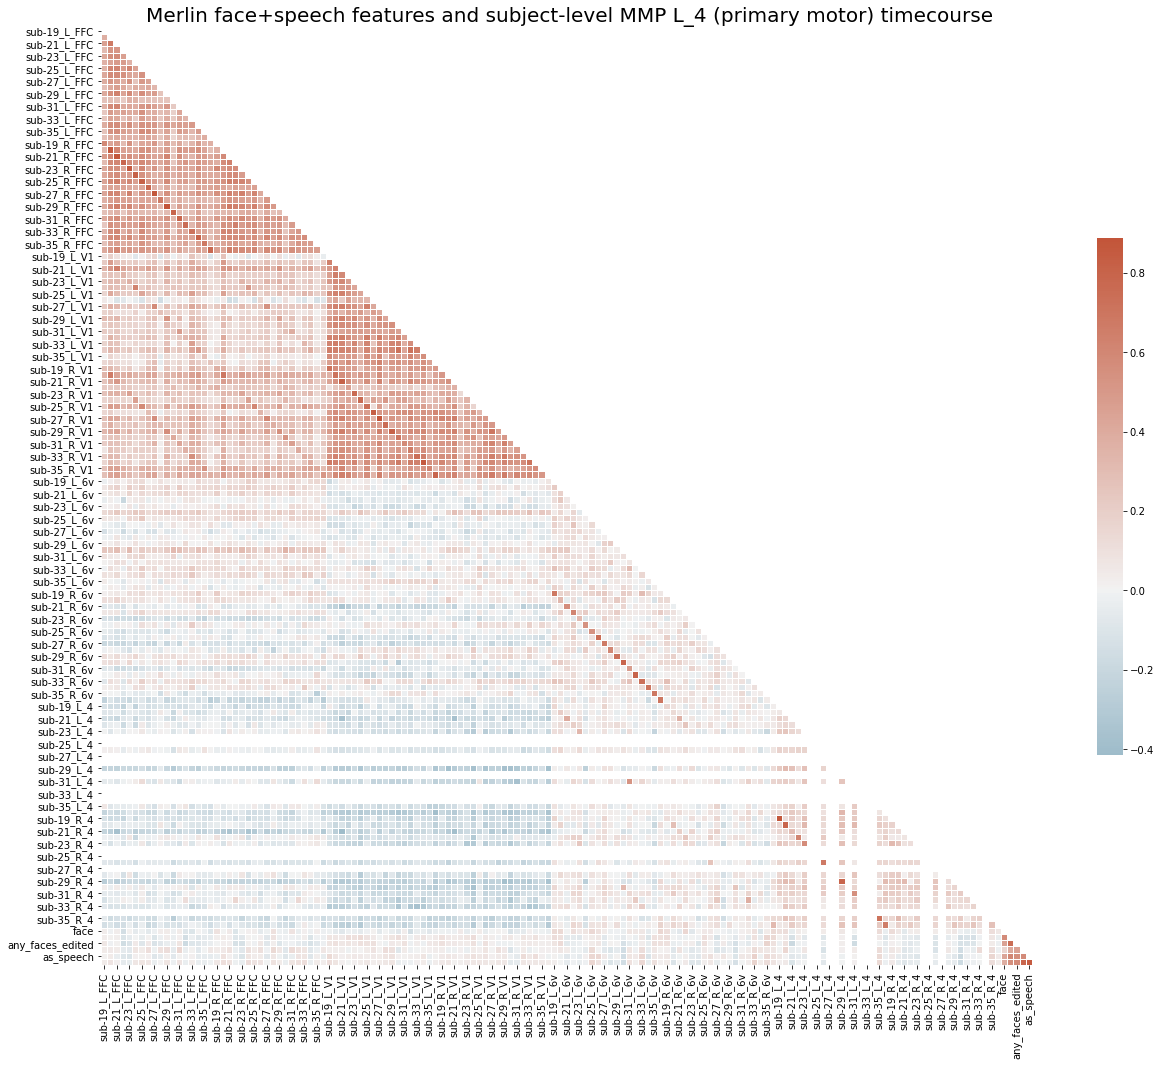

In [263]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Merlin face+speech features and subject-level MMP L_4 (primary motor) timecourse", fontsize =20)

## get all of the merlin neuroscout features [in pliers conda env] and save

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set("paper", "white")
from pyns import Neuroscout
import math

api = Neuroscout()

datasets = api.datasets.get()
print(f'dataset count = {len(api.datasets.get())}\n')
print('Datasets and IDs:\n')
for i in datasets:
    print(i['name'], i['id'])

subject = api.runs.get(dataset_id=5)[0]['subject']

api.runs.get(dataset_id=5, subject=subject,number=19)

runs = api.runs.get(dataset_id=5)
task_list = []
task_names = []
run_ids = []
for r in runs:
    task_list.append(r['task'])
    task_names.append(r['task_name'])
    run_ids.append(r['id'])
task_list,ind = np.unique(np.asarray(task_list),return_index=True)

task_name_list = []
run_id_list = []
for i in ind:
    task_name_list.append(task_names[i])
    run_id_list.append(run_ids[i])
print(task_list)
print(task_name_list)
print(run_id_list)

def get_predictors(run_id):
    # input: a neuroscout run_id 
    # outputs:
    # - a pandas dataframe of predictors
    # - list of ids
    # - list of names
    # - list of modality
    predictors=api.predictors.get(run_id=run_id)
    predictor_ids = []
    predictor_names = []
    predictor_modality = []
    for i in predictors:
        if not i['source'] == 'fmriprep' and not i['mean'] == None and str(i['name']).find("bert") < 0:
            predictor_ids.append(i['id'])
            predictor_names.append(i['name'])
            try:
                predictor_modality.append(i['extracted_feature']['modality'])
            except:
                predictor_modality.append(None)
                
    df_predictors=pd.DataFrame(data= np.array([predictor_ids,predictor_modality,predictor_names]).T , columns=['id','modality','names'])
    df_predictors = df_predictors.sort_values(by=['id','names','modality'])
    predictor_ids= df_predictors['id'].to_numpy()
    predictor_names= df_predictors['names'].to_numpy()
    predictor_modality= df_predictors['modality'].to_numpy()



    return(df_predictors, predictor_ids, predictor_names, predictor_modality)

def get_timeseries(predictor_ids,run_id,run_duration):
    # input: list of predictor IDs
    # output: an array of predictors as 1 hz timeseries
    #
    ### given an event... convert it from duration onset value to timeseries
    # - sort it (the dicts are out of order)
    # - convert to timeseries
    # - resample it to 1 hz now as a start
    all_feats = []
    for pred_id in predictor_ids:
        an_event=api.predictor_events.get(predictor_id=pred_id,run_id=run_id,stimulus_timing=True)
        data = np.zeros((int(run_duration)))
        for i in an_event:
            start = round(i['onset'])
            stop = start + math.ceil(i['duration'])
            value = i['value']
            #onset=round(onset)
            try:
                data[start:stop]=value
            except:
                #print()
                print(f'skipped {value}')

        all_feats.append(data)
    all_feats = np.asarray(all_feats)
    return(all_feats)
    #all_feats is length = # predictors each predictor is size = run duration

import dcor

#merlin:
run_id =1410
task_name = task_name_list[i]
task = task_list[i]
subject = api.runs.get(task_id=task)[0]['subject']

run_duration=api.runs.get(dataset_id=5, subject=subject)[0]['duration']

df_predictors, predictor_ids, predictor_names, predictor_modality = get_predictors(run_id)

all_feats = get_timeseries(predictor_ids,run_id,run_duration)

df = pd.DataFrame(data=all_feats.T,columns =predictor_names)

#%time result = df.apply(lambda col1: df.apply(lambda col2: dcor.distance_correlation(col1, col2)))
#dcor_matrix = result.values
#sns.clustermap(result, cmap="viridis",figsize=(30, 30), xticklabels=True, yticklabels=True)
#plt.title(f'{task_name}, dcor clustermap')
#plt.savefig(f'../outputs/dcor_{task_name}.png')
#plt.close()

np.save('../sourcedata/data/merlin/features/ns_all_feats.npy', all_feats)
df.to_csv('../sourcedata/data/merlin/features/ns_all_feats.csv')

## process all of the merlin neuroscout features [in pliers conda env] and save

In [264]:
#all_feats=np.load('../sourcedata/data/merlin/features/ns_all_feats.npy')
df=pd.read_csv('../sourcedata/data/merlin/features/ns_all_feats.csv')
all_feats=df.to_numpy().T
all_feats.shape
all_feats=all_feats[:,25:].T #trim beginning to match brain and other features
all_feats_hrf=hrf_tools.apply_optimal_hrf_10hz(all_feats,1) #apply optimal HRF
#list(df) #list of column features

In [265]:
all_feats.shape

(1518, 173)

In [266]:
resampled_all_feats_hrf=[]
for r in np.arange(all_feats_hrf.shape[1]):
    resampled_all_feats_hrf.append(scipy.signal.resample(all_feats_hrf[:,r], 1009))
resampled_all_feats_hrf=np.asarray(resampled_all_feats_hrf).T
resampled_all_feats_hrf.shape

(1009, 173)

In [267]:
for ff in list(df):
    sub_list.append(ff)

In [268]:
timecourse_list=np.hstack((timecourse_list,resampled_all_feats_hrf))
df = pd.DataFrame(timecourse_list, columns = sub_list)

Text(0.5, 1.0, 'Merlin features and timecourse')

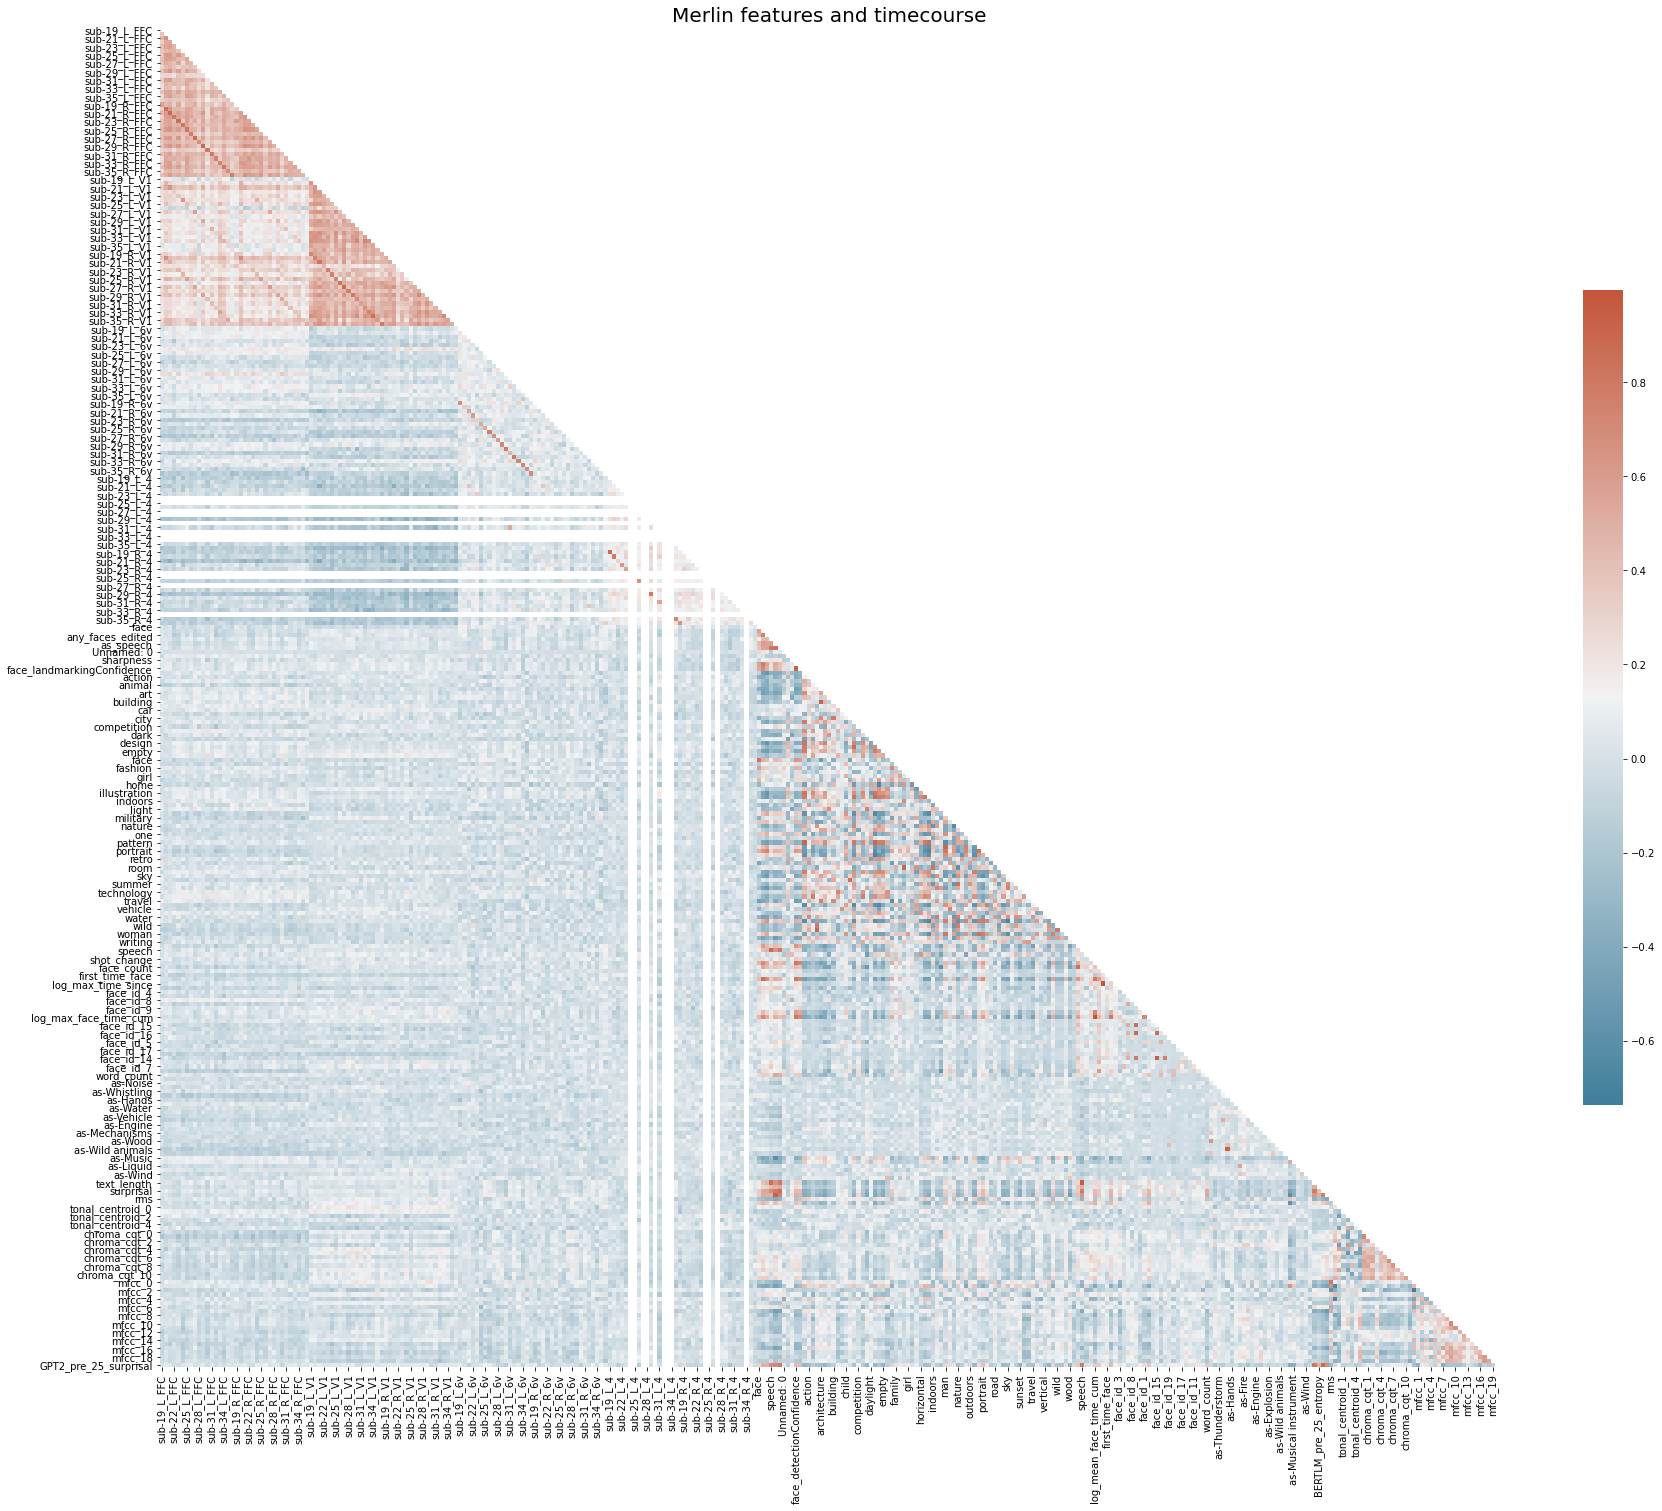

In [270]:

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 30))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=0, cbar_kws={"shrink": .5})



plt.title("Merlin features and timecourse", fontsize =20)

Text(0.5, 1.0, 'Merlin features and timecourse')

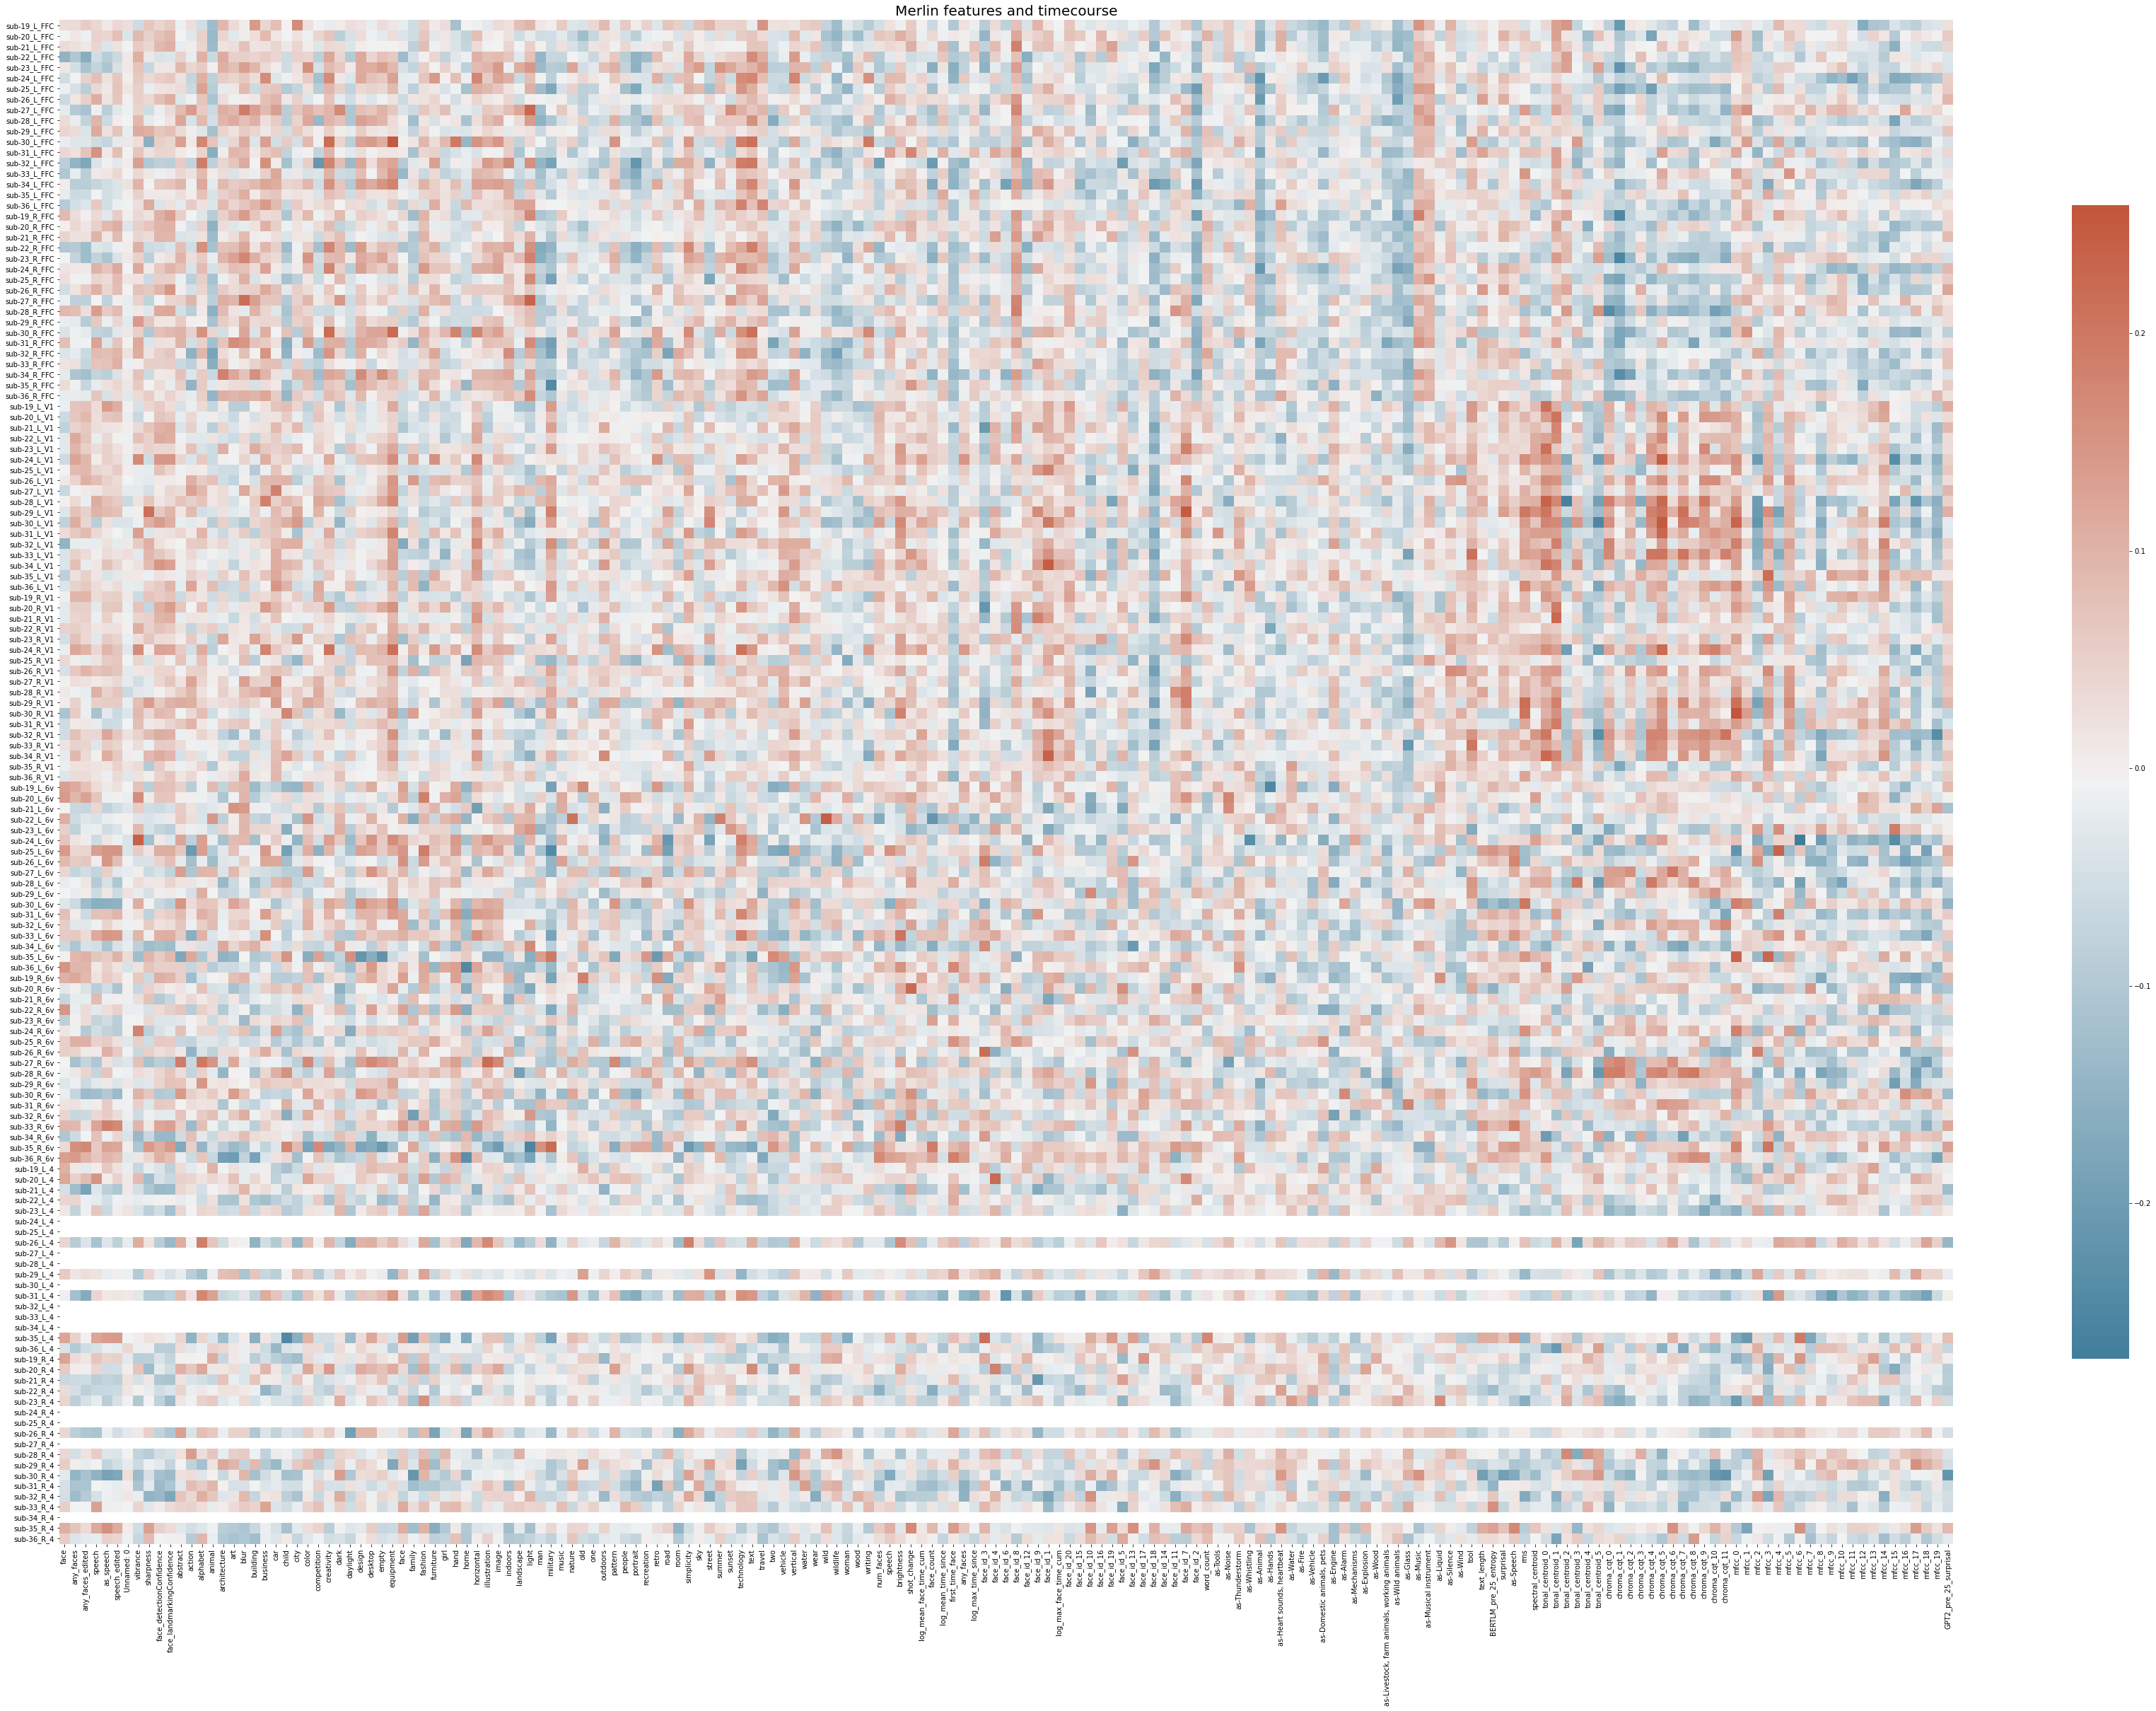

In [280]:
f, ax = plt.subplots(figsize=(60, 60))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.iloc[0:144,144:], cmap=cmap, square=True, linewidths=0, cbar_kws={"shrink": .5})



plt.title("Merlin features and timecourse", fontsize =20)